# Predicting Diamond Prices

### Data Set Information:

**A dataset containing the prices and other features of almost 54,000 diamonds.**

### Features description

**Number of Attributes: 10 (9 predictive features, 1 target)**

Feature Information: A data frame with 53,940 rows and 10 variables:

price: price in US dollars (\$326--\$18,823) **(target)**

carat: weight of the diamond (0.2--5.01)

cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)

color: diamond colour, from J (worst) to D (best)

clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

x: length in mm (0--10.74)

y: width in mm (0--58.9)

z: depth in mm (0--31.8)

depth: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

table: width of top of diamond relative to widest point (43--95)

In [1]:
# Importing useful libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
%matplotlib inline

## 0. Data Preparation

In [2]:
# importing data
data_path= '../data/diamonds.csv'
diamonds = pd.read_csv(data_path)

In [3]:
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
diamonds.shape

(53940, 10)

In [5]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
carat      53940 non-null float64
cut        53940 non-null object
color      53940 non-null object
clarity    53940 non-null object
depth      53940 non-null float64
table      53940 non-null float64
price      53940 non-null int64
x          53940 non-null float64
y          53940 non-null float64
z          53940 non-null float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


One of the transformations we must perform is to tranform the categorical features to the one-hot-encoding format.

In [6]:
print(diamonds['cut'].unique())
print(diamonds['color'].unique())
print(diamonds['clarity'].unique())

['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
['E' 'I' 'J' 'H' 'F' 'G' 'D']
['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']


In [ ]:
diamonds['cut'].head()

In [7]:
diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['cut'], prefix='cut', drop_first=True)],axis=1)
diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['color'], prefix='color', drop_first=True)],axis=1)
diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['clarity'], prefix='clarity', drop_first=True)],axis=1)
diamonds.drop(['cut','color','clarity'], axis=1, inplace=True)

In [8]:
diamonds.head()

,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,1,0,0,...,0,0,1,0,0,1,0,0,0,0


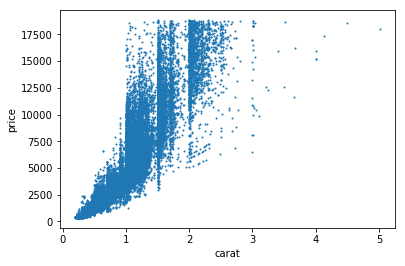

In [9]:
diamonds.plot.scatter(x='carat', y='price', s=1);

In [10]:
# To account for the non-linearity let's calculate the square of carat
diamonds['carat_squared'] = diamonds['carat']**2

### Scaling: an important operation

Since the features have different scales (<code>carat</code> goes from 0 to 5, <code>y</code> goes from 0 to 58) we need to be careful. Making sure that each feature has approximately the same scale can be a crucial preprocessing step. In this case we will use the <code>RobustScaler</code> object which scales the features to a common scale and it is robust to outliers.

### Getting the train and test sets

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler

In [12]:
target_name = 'price'
robust_scaler = RobustScaler()
X = diamonds.drop('price', axis=1)
X = robust_scaler.fit_transform(X)
y = diamonds[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### Preparing a DataFrame for model analysis

In [13]:
models = pd.DataFrame(index=['train_mse', 'test_mse'], 
                      columns=['NULL', 'MLR', 'KNN', 'LASSO'])

## The Null model: always predict the average of the target

In [14]:
y_pred_null = y_train.mean()
models.loc['train_mse','NULL'] = mean_squared_error(y_pred=np.repeat(y_pred_null, y_train.size), 
                                                    y_true=y_train)
models.loc['test_mse','NULL'] = mean_squared_error(y_pred=np.repeat(y_pred_null, y_test.size), 
                                                   y_true=y_test)

## A. Multiple Linear Regression

In [15]:
# 1. Import the estimator object (model)
from sklearn.linear_model import LinearRegression
# 2. Create an instance of the estimator
linear_regression = LinearRegression()
# 3. Use the trainning data to train the estimator
linear_regression.fit(X_train, y_train)
# 4. Evaluate the model
models.loc['train_mse','MLR'] = mean_squared_error(y_pred=linear_regression.predict(X_train), 
                                                    y_true=y_train)

models.loc['test_mse','MLR'] = mean_squared_error(y_pred=linear_regression.predict(X_test), 
                                                   y_true=y_test)

## B. K-Nearest Neighbors Model

In [16]:
# 1. Import the estimator object (model)
from sklearn.neighbors import KNeighborsRegressor
# 2. Create an instance of the estimator
knn = KNeighborsRegressor(n_neighbors=10, weights='distance', metric='euclidean', n_jobs=-1)
# 3. Use the trainning data to train the estimator
knn.fit(X_train, y_train)
# 4. Evaluate the model
models.loc['train_mse','KNN'] = mean_squared_error(y_pred=knn.predict(X_train), 
                                                    y_true=y_train)

models.loc['test_mse','KNN'] = mean_squared_error(y_pred=knn.predict(X_test), 
                                                   y_true=y_test)

## C. Lasso

In [17]:
# 1. Import the estimator object (model)
from sklearn.linear_model import Lasso
# 2. Create an instance of the estimator
lasso = Lasso(alpha=0.1)
# 3. Use the trainning data to train the estimator
lasso.fit(X_train, y_train)
# 4. Evaluate the model
models.loc['train_mse','LASSO'] = mean_squared_error(y_pred=lasso.predict(X_train), 
                                                    y_true=y_train)

models.loc['test_mse','LASSO'] = mean_squared_error(y_pred=lasso.predict(X_test), 
                                                   y_true=y_test)

C:\Users\Alvaro\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [18]:
models

,NULL,MLR,KNN,LASSO
train_mse,1.59239e+07,1.25084e+06,73.6507,1.2509e+06
test_mse,1.58811e+07,1.2489e+06,583118,1.24941e+06


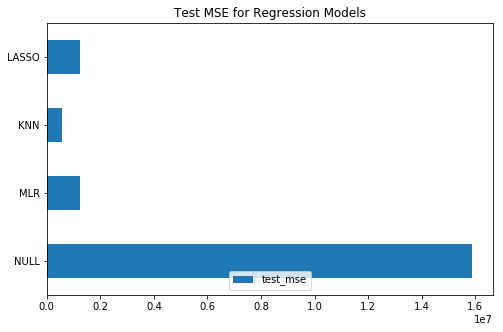

In [19]:
fig, ax = plt.subplots(figsize=(8,5))
models.loc['test_mse'].plot(kind='barh', ax=ax)
ax.set_title('Test MSE for Regression Models')
ax.legend(loc=8, ncol=4);

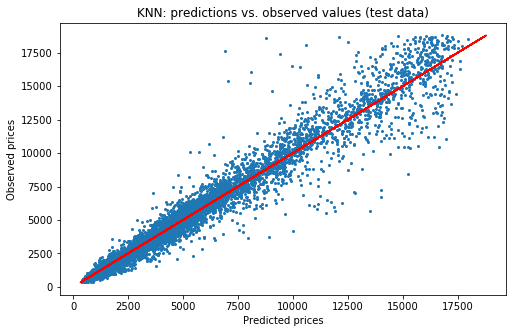

In [20]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(knn.predict(X_test), y_test, s=4)
ax.plot(y_test, y_test, color='red')
ax.set_title('KNN: predictions vs. observed values (test data)')
ax.set_xlabel('Predicted prices')
ax.set_ylabel('Observed prices');

## Using the best model to predict the price of a diamond

If you are happy with your model we can re-train it using all observations, and then use it to make predictions.

In [21]:
# Re-training with all the observations
knn_final = KNeighborsRegressor(n_neighbors=10, weights='distance', metric='euclidean', n_jobs=-1)
# 3. Use the trainning data to train the estimator
knn_final.fit(X, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='euclidean',
          metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
          weights='distance')

In [24]:
# Making predictions
new_diamond = OrderedDict([('carat',0.45), ('depth',62.3), ('table',59.0), ('x',3.95),
                           ('y',3.92), ('z',2.45), ('cut_Good',0.0), ('cut_Ideal',0.0),
                           ('cut_Premium',1.0), ('cut_Very Good',0.0), ('color_E',0.0), 
                           ('color_F',0.0), ('color_G',1.0), ('color_H',0.0), ('color_I',0.0),
                           ('color_J',0.0), ('clarity_IF',0.0), ('clarity_SI1',0.0),
                           ('clarity_SI2',0.0), ('clarity_VS1',0.0), ('clarity_VS2',0.0),
                           ('clarity_VVS1',1.0), ('clarity_VVS2',0.0), ('carat_squared',0.0576)])

new_diamond = pd.Series(new_diamond).values.reshape(1,-1)

In [25]:
knn_final.predict(new_diamond)

array([ 5825.37095351])